# Folded Peptides
This notebook loads in the data generated with AlphaFold2 and apply some machine learning ot it

# Preliminars

In [1]:
module("load","cuda/11.2")
module("load","tensorflow/gpu-cuda-11.2/2.5.0")

In [2]:
import tensorflow as tf

2021-12-01 20:53:03.493532: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [4]:
import wandb

In [112]:
wandb.init(project="prot_alphafold2_pep", entity="jlrestrepol")

2021-11-30 11:13:56.257294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
device_name = tf.test.gpu_device_name()

2021-12-01 20:53:09.895689: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-01 20:53:10.013841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-12-01 20:53:10.013873: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-01 20:53:10.020427: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-01 20:53:10.020488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-01 20:53:10.022184: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft

In [8]:
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
distance_list = pd.read_pickle('distance_list.pkl')
seq_list = pd.read_pickle('seq_dist_list.pkl')

## Labels

In [10]:
fig1 = pd.read_pickle('/u/jrlopez/Fig1_powerlaw.pkl')
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_', '')
fig1_ch2 = fig1[fig1['Charge']==2]
fig1_ch2 = fig1_ch2.set_index('Modified sequence')

In [35]:
labels = fig1_ch2.loc[seq_list,:]['CCS'].values 

# Resizing

In [15]:
tensors = [tf.convert_to_tensor(e[:,:,np.newaxis], dtype=tf.float32) for e in distance_list]

In [16]:
images = [tf.image.convert_image_dtype(tensor, tf.float32) for tensor in tensors]#normalize to (0,1)

In [17]:
images_std = [tf.image.per_image_standardization(image) for image in images]

In [18]:
images_array = np.array([tf.image.resize(image, (227, 227)) for image in images_std])

In [ ]:
tf.constant([[0,1], [2,3]])

# Padding

In [10]:
def pad(a):
    """Return bottom right padding."""
    zeros = np.zeros((227,227))
    zeros[:a.shape[0], :a.shape[1]] = a
    return zeros

In [11]:
def normalize(a):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    norm = (a-mean[0])/std[0]
    return norm

In [12]:
padded_images = np.array([pad(normalize(a))[:,:,np.newaxis] for a in distance_list])

In [13]:
images_tf = tf.stack(padded_images)

2021-12-01 16:43:11.990623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-12-01 16:43:11.993698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-12-01 16:43:11.996571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-12-01 16:43:11.999578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-12-01 16:43:11.999610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-01 16:43:11.999616: I tensorflow/core/c

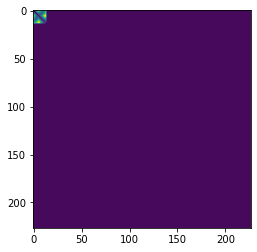

In [14]:
plt.imshow(padded_images[5])

# Train/val set split

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(padded_images, labels, test_size = 0.1, random_state = 23112021)

In [127]:
global label_scaler
label_scaler = StandardScaler()
label_scaler.fit(y_train.reshape(-1, 1))
y_train_sc = label_scaler.transform(y_train.reshape(-1, 1))
y_val_sc = label_scaler.transform(y_val.reshape(-1, 1))

In [182]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_sc))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_sc))

In [183]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
print("Training data size:", train_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 11211
Validation data size: 1246


In [184]:
train_ds = (train_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=1, drop_remainder=True))

val_ds = (val_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=1, drop_remainder=True))

In [32]:
tf.data.experimental.save(train_ds, '../../train_extended')

2021-11-25 15:18:25.759693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-25 15:18:25.768644: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


In [33]:
tf.data.experimental.save(val_ds, '../../val_extended')

## Load in

In [70]:
del train_ds, val_ds

In [248]:
train_ds = tf.data.experimental.load('../../train_extended', tf.TensorSpec(shape=(None,227,227,1), dtype=tf.float32))
val_ds = tf.data.experimental.load('../../val_extended', tf.TensorSpec(shape=(None,227,227,1), dtype=tf.float32))

2021-12-01 12:54:51.613478: E tensorflow/core/framework/dataset.cc:825] Unimplemented: Cannot merge options for dataset of type LoadDataset, because the dataset does not implement `InputDatasets`.
2021-12-01 12:54:51.701579: E tensorflow/core/framework/dataset.cc:825] Unimplemented: Cannot merge options for dataset of type LoadDataset, because the dataset does not implement `InputDatasets`.


In [59]:
#x_train = x_train[:,:,:,np.newaxis]
#x_val = x_val[:,:,:,np.newaxis]

# Architecture

In [185]:
#Importing library
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [240]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

# Callbacks

In [227]:
from wandb.keras import WandbCallback
import tensorflow.keras.backend as K

In [228]:
pred = model.predict(x_val)
mean_squared_error(pred*59.36563519+414.34814871, y_val_sc*59.36563519+414.34814871)

4206.747604309568

In [229]:
def mse_scaled(y_true, y_pred):
    labels = y_true
    preds = y_pred
    preds_scaled = preds*59.36563519+414.34814871
    labels_scaled = labels*59.36563519+414.34814871
    mse_scaled = K.mean(K.square(preds_scaled - labels_scaled), axis=-1)
    return mse_scaled

In [224]:
model.compile(loss = "mean_squared_error", optimizer=tf.optimizers.SGD(lr=0.001, clipnorm = 1), metrics=[mse_scaled])

/mpcdf/soft/SLE_15/packages/skylake/tensorflow/gpu-cuda-11.2/anaconda_3_2020.02-2020.02/2.5.0/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [225]:
np.allclose(y_val, (y_val_sc*59.36563519+414.34814871).flatten())

True

# Trainig

In [220]:
model.fit(train_ds, epochs = 4, validation_data=val_ds, validation_freq=1)

Epoch 1/4
11211/11211 [==============================] - 128s 11ms/step - loss: 4.5616 - mse_scaled: 16076.2783 - val_loss: 0.5478 - val_mse_scaled: 1930.6443
Epoch 2/4
11211/11211 [==============================] - 125s 11ms/step - loss: 1.0776 - mse_scaled: 3797.8911 - val_loss: 0.5516 - val_mse_scaled: 1944.0249
Epoch 3/4
 4535/11211 [===========>..................] - ETA: 1:10 - loss: 0.4622 - mse_scaled: 1628.7468

KeyboardInterrupt: 

In [148]:
model.fit(train_ds, epochs = 20, validation_data=val_ds, validation_freq=1)

Epoch 1/20
350/350 [==============================] - 9s 18ms/step - loss: 127721.0859 - val_loss: 105669.3125
Epoch 2/20
350/350 [==============================] - 7s 17ms/step - loss: 21134.7461 - val_loss: 16577.3066
Epoch 3/20
350/350 [==============================] - 8s 20ms/step - loss: 1801.8323 - val_loss: 2032.1055
Epoch 4/20
350/350 [==============================] - 8s 21ms/step - loss: 1411.9485 - val_loss: 1048.4812
Epoch 5/20
350/350 [==============================] - 9s 20ms/step - loss: 1295.3125 - val_loss: 750.4927
Epoch 6/20
350/350 [==============================] - 8s 20ms/step - loss: 1140.7584 - val_loss: 788.6707
Epoch 7/20
350/350 [==============================] - 7s 19ms/step - loss: 1081.2740 - val_loss: 588.1708
Epoch 8/20
350/350 [==============================] - 7s 17ms/step - loss: 1011.1448 - val_loss: 847.0958
Epoch 9/20
350/350 [==============================] - 7s 19ms/step - loss: 967.5139 - val_loss: 586.5483
Epoch 10/20
350/350 [================

In [ ]:
wandb.finish()

## Custom Training loop

In [241]:
optimizer = tf.optimizers.SGD(lr=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()
val_metric = tf.keras.metrics.MeanSquaredError()
train_metric = tf.keras.metrics.MeanSquaredError()

In [242]:
batch_size = 32
for epoch in np.arange(10):
    print(f"epoch {epoch}. Training")

    # get trainable variables
    train_vars = model.trainable_variables
    # Create empty gradient list (not a tf.Variable list)
    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    total_loss = 0
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        #image = image[np.newaxis,:,:,:].astype("float32")
        #label = np.array(label).reshape(1,-1).astype("float32")
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training = True)
            logits = logits[0]
            loss_value = loss_fn(y_batch_train, logits)
            total_loss += loss_value
        grads = tape.gradient(loss_value, train_vars)
        ##grads = [tf.clip_by_norm(grad, 2) for grad in grads]
        #grads = tf.clip_by_global_norm(grads, 1.0) for grad in grads]
        #optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_metric.update_state(y_batch_train, logits)
        # Accumulate the gradients
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, grads)]
        

        if (step%batch_size==0) or (len(x_train) - step == 1):
            accum_gradient = [tf.clip_by_norm(grad, 1) for grad in accum_gradient]
            #accum_gradient = [this_grad/batch_size for this_grad in accum_gradient]
            optimizer.apply_gradients(zip(accum_gradient, model.trainable_variables), experimental_aggregate_gradients=False)            
            # Create empty gradient list (not a tf.Variable list)
            train_vars = model.trainable_variables
            accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
            
            continue
    
    error_train = train_metric.result()
    train_metric.reset_states()

    predicted = np.zeros_like(y_val, dtype = "float32")
    for j, (x_batch_val, y_batch_val) in enumerate(val_ds):
        #image = image[np.newaxis,:,:,:].astype("float32")
        val_logits = model(x_batch_val, training = False)
        val_metric.update_state(val_logits, y_batch_val)
    error = val_metric.result()
    val_metric.reset_states()

    print(f'Epoch loss = {error_train}. Validation loss = {error}')

epoch 0. Training
Epoch loss = 7.727229595184326. Validation loss = 1.533576488494873
epoch 1. Training
Epoch loss = 4.92893648147583. Validation loss = 0.8822929859161377
epoch 2. Training
Epoch loss = 3.4323785305023193. Validation loss = 0.7458745837211609
epoch 3. Training
Epoch loss = 2.3716514110565186. Validation loss = 0.7020072340965271
epoch 4. Training
Epoch loss = 1.7719653844833374. Validation loss = 0.6269655227661133
epoch 5. Training
Epoch loss = 1.331405520439148. Validation loss = 0.5953965783119202
epoch 6. Training
Epoch loss = 0.9879685044288635. Validation loss = 0.675258457660675
epoch 7. Training
Epoch loss = 0.7705870866775513. Validation loss = 0.6097710132598877
epoch 8. Training
Epoch loss = 0.5831345915794373. Validation loss = 0.5233178734779358
epoch 9. Training
Epoch loss = 0.4791673719882965. Validation loss = 0.5908235907554626


# Fully Convolutional Network

# Data

In [36]:
import pickle

In [37]:
shapes = np.array(list(map(lambda x: x.shape[0], distance_list)))
idx = [e >= 9 for e in shapes]

In [38]:
distance_sublist = np.array(distance_list, dtype=object)[idx].tolist()
labels_sublist = labels[idx]

In [ ]:
with open("../../sublist.pkl", "wb") as handle:
    pickle.dump(distance_sublist, handle)

In [ ]:
with open("../../sublabels.pkl", "wb") as handle:
    pickle.dump(labels_sublist, handle)

### Load-in 

In [17]:
from sklearn.preprocessing import StandardScaler
import pickle

In [247]:
with open("../../sublist.pkl", "rb") as handle:
    distance_sublist = pickle.load(handle)

In [248]:
with open("../../sublabels.pkl", "rb") as handle:
    labels_sublist = pickle.load(handle)

In [39]:
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(distance_sublist, labels_sublist, test_size = 0.1, random_state = 23112021)

In [41]:
label_scaler = StandardScaler()

In [42]:
label_scaler.fit(y_train.reshape(-1, 1))
y_train_sc = label_scaler.transform(y_train.reshape(-1, 1))
y_val_sc = label_scaler.transform(y_val.reshape(-1, 1))

In [43]:
train_flat = np.hstack([e.flatten() for e in x_train])
x_mean = np.mean(train_flat)
x_std = np.std(train_flat)

In [44]:
x_train_sc = list(map(lambda x : (x - x_mean)/x_std, x_train))
x_val_sc = list(map(lambda x : (x - x_mean)/x_std, x_val))

## Architecture

In [45]:

def FCN_model(len_classes=1, dropout_rate=0.5):
    
    inputs = tf.keras.layers.Input(shape=(None, None, 1))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    #x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2)(x)
    #x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Activation('relu')(x)

    # Uncomment the below line if you're using dense layers
    # x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Fully connected layer 1
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=64)(x)
    # x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 2
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=len_classes)(x)
    # predictions = tf.keras.layers.Activation('softmax')(x)

    # Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    #print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model

In [20]:
fcn = FCN_model()
fcn.compile(loss = "mean_squared_error", optimizer= tf.keras.optimizers.Adam(lr=0.0001, clipnorm = 1.0))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
activation_7 (Activation)    (None, None, None, 64)    0   

# Generator

In [21]:
class Generator(tf.keras.utils.Sequence):
    
    def __init__(self, matrices, labels, BATCH_SIZE=1, shuffle_images=True, image_min_side=24):
        """ Initialize Generator object.
        Args
            DATASET_PATH           : Path to folder containing individual folders named by their class names
            BATCH_SIZE             : The size of the batches to generate.
            shuffle_images         : If True, shuffles the images read from the DATASET_PATH
            image_min_side         : After resizing the minimum side of an image is equal to image_min_side.
        """

        self.batch_size = BATCH_SIZE
        self.shuffle_images = shuffle_images
        self.image_groups = matrices
        self.label_groups = labels

    def __len__(self):
        """
        Number of batches for generator.
        """

        return len(self.image_groups)

    def __getitem__(self, index):
        """
        Keras sequence method for generating batches.
        """
        label_group = np.array(self.label_groups[index]).reshape(1,-1)
        images = [self.image_groups[index][:,:,np.newaxis]]
        image_batch = np.zeros((self.batch_size,)+images[0].shape)
        for image_index, image in enumerate(images):
            image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

        return image_batch, label_group

In [140]:
train_generator = Generator(x_train, y_train)

In [135]:
val_generator = Generator(x_val, y_val)

In [ ]:
history = fcn.fit(train_generator, epochs = 20, validation_data = val_generator, steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

Epoch 1/20
10438/10438 [==============================] - 106s 10ms/step - loss: 143.8248 - val_loss: 129.7308
Epoch 2/20
10438/10438 [==============================] - 106s 10ms/step - loss: 136.8429 - val_loss: 129.7198
Epoch 3/20
10438/10438 [==============================] - 106s 10ms/step - loss: 138.5665 - val_loss: 129.7310
Epoch 4/20
10438/10438 [==============================] - 105s 10ms/step - loss: 138.7012 - val_loss: 129.6603
Epoch 5/20
10438/10438 [==============================] - 106s 10ms/step - loss: 144.8352 - val_loss: 129.7163
Epoch 6/20
10438/10438 [==============================] - 106s 10ms/step - loss: 140.4478 - val_loss: 129.7362
Epoch 7/20
10438/10438 [==============================] - 106s 10ms/step - loss: 135.2414 - val_loss: 129.7063
Epoch 8/20
10438/10438 [==============================] - 106s 10ms/step - loss: 138.9927 - val_loss: 128.1890
Epoch 9/20
10438/10438 [==============================] - 105s 10ms/step - loss: 138.7748 - val_loss: 127.6629
E

## Train Loop from Scratch

In [46]:
fcn = FCN_model()
optimizer = tf.optimizers.SGD(lr=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()
val_metric = tf.keras.metrics.MeanSquaredError()
train_metric = tf.keras.metrics.MeanSquaredError()

Total number of layers: 20


/mpcdf/soft/SLE_15/packages/skylake/tensorflow/gpu-cuda-11.2/anaconda_3_2020.02-2020.02/2.5.0/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
predicted = np.zeros_like(y_val_sc, dtype = "float32")
for j, (image, label) in enumerate(zip(x_val_sc, y_val_sc)):
    image = image[np.newaxis,:,:,np.newaxis].astype("float32")
    predicted[j] = fcn(image, training = False)
error = loss_fn(predicted, y_val_sc).numpy()
f'The initial validation error is {error}'

'The initial validation error is 0.9747118949890137'

In [48]:
batch_size = 32
for epoch in np.arange(10):
    print(f"epoch {epoch}. Training")
    total_loss = 0

    # get trainable variables
    train_vars = fcn.trainable_variables
    # Create empty gradient list (not a tf.Variable list)
    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    
    for step, (x_batch_train, y_batch_train) in enumerate(zip(x_train_sc, y_train_sc)):
        x_batch_train = x_batch_train[np.newaxis,:,:,np.newaxis].astype("float64")
        y_batch_train = np.array([y_batch_train]).astype("float64")
        with tf.GradientTape() as tape:
            logits = fcn(x_batch_train, training = True)
            logits = logits[0]
            loss_value = loss_fn(y_batch_train, logits)
            total_loss += loss_value
        grads = tape.gradient(loss_value, train_vars)
        ##grads = [tf.clip_by_norm(grad, 1.0) for grad in grads]
        # Accumulate the gradients
        train_metric.update_state(y_batch_train, logits)
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, grads)]
        
        if (step%batch_size==0) or (len(x_train_sc) - step == 1):
            grads = [tf.clip_by_norm(grad, 5) for grad in accum_gradient]
            #accum_gradient = [this_grad/batch_size for this_grad in accum_gradient]
            optimizer.apply_gradients(zip(accum_gradient, fcn.trainable_variables), experimental_aggregate_gradients=False)

            # Create empty gradient list (not a tf.Variable list)
            train_vars = fcn.trainable_variables
            accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
            continue
    
    error_train = train_metric.result()
    train_metric.reset_states()        

    predicted = np.zeros_like(y_val, dtype = "float32")
    for j, (x_batch_val, y_batch_val) in enumerate(zip(x_val_sc, y_val_sc)):
        x_batch_val = x_batch_val[np.newaxis,:,:,np.newaxis].astype("float32")
        val_logits = fcn(x_batch_val, training = False)
        val_metric.update_state(val_logits, y_batch_val)
    error = val_metric.result()
    val_metric.reset_states()
    
    print(f'Epoch loss = {error_train}. Validation loss = {error}')

epoch 0. Training
Epoch loss = 0.5463468432426453. Validation loss = 0.4894874691963196
epoch 1. Training
Epoch loss = 0.45629915595054626. Validation loss = 0.4871244728565216
epoch 2. Training
Epoch loss = 0.43855020403862. Validation loss = 0.44011732935905457
epoch 3. Training
Epoch loss = 0.43151620030403137. Validation loss = 0.5166045427322388
epoch 4. Training
Epoch loss = 0.427420437335968. Validation loss = 0.4463052749633789
epoch 5. Training
Epoch loss = 0.4262346923351288. Validation loss = 0.47982046008110046
epoch 6. Training
Epoch loss = 0.41545259952545166. Validation loss = 0.4424302279949188
epoch 7. Training
Epoch loss = 0.4245167076587677. Validation loss = 0.43822750449180603
epoch 8. Training
Epoch loss = 0.42620664834976196. Validation loss = 0.4489021599292755
epoch 9. Training
Epoch loss = 0.41744551062583923. Validation loss = 0.45573294162750244
